<a href="https://colab.research.google.com/github/Yin039/AI_Models/blob/main/2-layer%20MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Build a 2-layer MLP for fetus classification**

In [ ]:
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import random
import torch
import torch.nn as nn
import torch.optim as optim

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

    # Set PyTorch random seed for CPU and GPU (if available)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

    # Make sure that the results are deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set a fixed seed for reproducibility
set_seed(42)

In [ ]:
# load datasets
train_data = pd.read_csv('/content/gdrive/MyDrive/WOA7015 GA/Fetus_trainingdata.csv')
test_data = pd.read_csv('/content/gdrive/MyDrive/WOA7015 GA/Fetus_testingdata.csv')

# read/sort the two datasets
X_train = train_data.iloc[:, 1:17].values   # second to last column are features, 16 features in total
Y_train = train_data.iloc[:, 0].values  # first column is outcome
X_test = test_data.iloc[:, 1:17].values
Y_test = test_data.iloc[:, 0].values

In [ ]:
from sklearn.preprocessing import StandardScaler

# scale the features based on training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder

# Use LabelEncoder to convert string labels to numerical labels
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_test_encoded = label_encoder.transform(Y_test)

# convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train_encoded, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test_encoded, dtype=torch.long)

# create DataLoader for training and testing datasets
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)


## BUILD THE MODEL WITH THE PYTORCH nn.MODULE

nn.Module is a fundamental class in PyTorch used to create custom neural network architectures. It is a base class for all neural network modules in PyTorch, and it provides several essential functionalities for building and managing neural networks.

When creating a custom neural network in PyTorch, you typically create a subclass of nn.Module and define the architecture by specifying the layers and operations that make up your neural network.

Here is how the MLP looks like in code:

In [ ]:
# define a MLP model
class MLP(torch.nn.Module):
    def __init__(self, input_size=16, hidden_sizes=[10], output_size=2, activation_fn="relu", dropout_rate=0):
        super(MLP, self).__init__()

        # Define layers based on the number of hidden layers and dropout
        layers = []
        in_features = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_features, hidden_size))
            if activation_fn == "relu":
                layers.append(nn.ReLU())
            elif activation_fn == "tanh":
                layers.append(nn.Tanh())
            layers.append(nn.Dropout(dropout_rate))
            in_features = hidden_size
        layers.append(nn.Linear(in_features, output_size))
        self.model = nn.Sequential(*layers)

# define a Prediction Function
    def forward(self, x):
        return self.model(x)

In [ ]:
from sklearn.model_selection import ParameterGrid, ParameterSampler

# Hyperparameter grid for grid search
param_grid = {
    "batch_size": [16, 32],
    "learning_rate": [0.01, 0.001, 0.0001],
    "hidden_sizes": [[10], [10, 5]],
    "activation_fn": ["relu", "tanh"],
    "dropout_rate": [0.0, 0.2],
}

# Generate all combinations of hyperparameters
param_list = list(ParameterGrid(param_grid))

In [ ]:
def train_model(params):
    # DataLoader instances
    train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=params["batch_size"], shuffle=False)

    # Instantiate model
    model = MLP(
        input_size=16,
        hidden_sizes=params["hidden_sizes"],
        output_size=2,
        activation_fn=params["activation_fn"],
        dropout_rate=params["dropout_rate"]
        )

    # Loss function
    criterion = nn.CrossEntropyLoss()
    # Adam optimizer to update model weight
    optimizer = optim.Adam(model.parameters(), lr=params["learning_rate"])

    num_epochs = 100
    training_losses = []
    testing_losses = []
    training_accuracies = []
    testing_accuracies = []

    best_testing_accuracy = 0

    # for loop to repeat the iterations
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_correct = 0

        for inputs, labels in train_loader:
          # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
            optimizer.zero_grad()
            outputs = model(inputs)

            # get loss for the predicted output
            loss = criterion(outputs, labels)

            # get gradients w.r.t to parameters
            loss.backward()

            # update parameters
            optimizer.step()

            train_loss += loss.item()
            # selects the class with the highest probability for each prediction
            _, predicted = torch.max(outputs, 1)
            # counts the correct predictions in the batch and adds to train_correct
            train_correct += (predicted == labels).sum().item()

        training_losses.append(train_loss / len(train_loader))
        training_accuracies.append(100 * train_correct / len(train_dataset))

        # Evaluate on testing data
        # Sets the model to evaluation mode (disables dropout and batch normalization)
        model.eval()
        test_loss = 0
        test_correct = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                test_correct += (predicted == labels).sum().item()

        testing_losses.append(test_loss / len(test_loader))
        testing_accuracy = 100 * test_correct / len(test_dataset)
        testing_accuracies.append(testing_accuracy)

        if testing_accuracy > best_testing_accuracy:
            best_testing_accuracy = testing_accuracy

    return {
        "training_loss": training_losses,
        "testing_loss": testing_losses,
        "training_accuracy": training_accuracies,
        "testing_accuracy": testing_accuracies,
        "best_testing_accuracy": best_testing_accuracy,
        "params": params,
    }

In [ ]:
from tqdm import tqdm
# Run grid search for every possible combination
results = []
for params in tqdm(param_list):
    result = train_model(params)
    results.append(result)
    print("\n Hyperparameters:", result["params"])
    print(f"Testing Accuracies: {result['best_testing_accuracy']:.3f}\n")

# Identify the best model by highest testing accuracy
best_model = max(results, key=lambda x: max(x["testing_accuracy"]))
print("\n Best Model Parameters:", best_model["params"])
print("\n Best Testing Accuracy:", max(best_model["testing_accuracy"]))

  2%|▏         | 1/48 [00:03<02:39,  3.39s/it]


 Hyperparameters: {'activation_fn': 'relu', 'batch_size': 16, 'dropout_rate': 0.0, 'hidden_sizes': [10], 'learning_rate': 0.01}
Testing Accuracies: 77.586



  4%|▍         | 2/48 [00:07<03:06,  4.06s/it]


 Hyperparameters: {'activation_fn': 'relu', 'batch_size': 16, 'dropout_rate': 0.0, 'hidden_sizes': [10], 'learning_rate': 0.001}
Testing Accuracies: 81.034



  6%|▋         | 3/48 [00:11<02:49,  3.76s/it]


 Hyperparameters: {'activation_fn': 'relu', 'batch_size': 16, 'dropout_rate': 0.0, 'hidden_sizes': [10], 'learning_rate': 0.0001}
Testing Accuracies: 68.966



  8%|▊         | 4/48 [00:15<02:47,  3.80s/it]


 Hyperparameters: {'activation_fn': 'relu', 'batch_size': 16, 'dropout_rate': 0.0, 'hidden_sizes': [10, 5], 'learning_rate': 0.01}
Testing Accuracies: 81.034



 10%|█         | 5/48 [00:19<02:51,  4.00s/it]


 Hyperparameters: {'activation_fn': 'relu', 'batch_size': 16, 'dropout_rate': 0.0, 'hidden_sizes': [10, 5], 'learning_rate': 0.001}
Testing Accuracies: 72.414



 12%|█▎        | 6/48 [00:24<03:02,  4.34s/it]


 Hyperparameters: {'activation_fn': 'relu', 'batch_size': 16, 'dropout_rate': 0.0, 'hidden_sizes': [10, 5], 'learning_rate': 0.0001}
Testing Accuracies: 67.241



 15%|█▍        | 7/48 [00:28<02:46,  4.07s/it]


 Hyperparameters: {'activation_fn': 'relu', 'batch_size': 16, 'dropout_rate': 0.2, 'hidden_sizes': [10], 'learning_rate': 0.01}
Testing Accuracies: 81.034



 17%|█▋        | 8/48 [00:31<02:35,  3.89s/it]


 Hyperparameters: {'activation_fn': 'relu', 'batch_size': 16, 'dropout_rate': 0.2, 'hidden_sizes': [10], 'learning_rate': 0.001}
Testing Accuracies: 72.414



 19%|█▉        | 9/48 [00:35<02:35,  3.99s/it]


 Hyperparameters: {'activation_fn': 'relu', 'batch_size': 16, 'dropout_rate': 0.2, 'hidden_sizes': [10], 'learning_rate': 0.0001}
Testing Accuracies: 67.241



 21%|██        | 10/48 [00:40<02:42,  4.29s/it]


 Hyperparameters: {'activation_fn': 'relu', 'batch_size': 16, 'dropout_rate': 0.2, 'hidden_sizes': [10, 5], 'learning_rate': 0.01}
Testing Accuracies: 81.034



 23%|██▎       | 11/48 [00:44<02:38,  4.27s/it]


 Hyperparameters: {'activation_fn': 'relu', 'batch_size': 16, 'dropout_rate': 0.2, 'hidden_sizes': [10, 5], 'learning_rate': 0.001}
Testing Accuracies: 74.138



 25%|██▌       | 12/48 [00:49<02:39,  4.42s/it]


 Hyperparameters: {'activation_fn': 'relu', 'batch_size': 16, 'dropout_rate': 0.2, 'hidden_sizes': [10, 5], 'learning_rate': 0.0001}
Testing Accuracies: 68.966



 27%|██▋       | 13/48 [00:52<02:17,  3.91s/it]


 Hyperparameters: {'activation_fn': 'relu', 'batch_size': 32, 'dropout_rate': 0.0, 'hidden_sizes': [10], 'learning_rate': 0.01}
Testing Accuracies: 75.862



 29%|██▉       | 14/48 [00:54<01:52,  3.32s/it]


 Hyperparameters: {'activation_fn': 'relu', 'batch_size': 32, 'dropout_rate': 0.0, 'hidden_sizes': [10], 'learning_rate': 0.001}
Testing Accuracies: 77.586



 31%|███▏      | 15/48 [00:56<01:34,  2.88s/it]


 Hyperparameters: {'activation_fn': 'relu', 'batch_size': 32, 'dropout_rate': 0.0, 'hidden_sizes': [10], 'learning_rate': 0.0001}
Testing Accuracies: 72.414



 33%|███▎      | 16/48 [00:58<01:26,  2.69s/it]


 Hyperparameters: {'activation_fn': 'relu', 'batch_size': 32, 'dropout_rate': 0.0, 'hidden_sizes': [10, 5], 'learning_rate': 0.01}
Testing Accuracies: 74.138



 35%|███▌      | 17/48 [01:00<01:19,  2.55s/it]


 Hyperparameters: {'activation_fn': 'relu', 'batch_size': 32, 'dropout_rate': 0.0, 'hidden_sizes': [10, 5], 'learning_rate': 0.001}
Testing Accuracies: 79.310



 38%|███▊      | 18/48 [01:03<01:15,  2.51s/it]


 Hyperparameters: {'activation_fn': 'relu', 'batch_size': 32, 'dropout_rate': 0.0, 'hidden_sizes': [10, 5], 'learning_rate': 0.0001}
Testing Accuracies: 70.690



 40%|███▉      | 19/48 [01:05<01:15,  2.60s/it]


 Hyperparameters: {'activation_fn': 'relu', 'batch_size': 32, 'dropout_rate': 0.2, 'hidden_sizes': [10], 'learning_rate': 0.01}
Testing Accuracies: 77.586



 42%|████▏     | 20/48 [01:08<01:10,  2.53s/it]


 Hyperparameters: {'activation_fn': 'relu', 'batch_size': 32, 'dropout_rate': 0.2, 'hidden_sizes': [10], 'learning_rate': 0.001}
Testing Accuracies: 75.862



 44%|████▍     | 21/48 [01:10<01:04,  2.39s/it]


 Hyperparameters: {'activation_fn': 'relu', 'batch_size': 32, 'dropout_rate': 0.2, 'hidden_sizes': [10], 'learning_rate': 0.0001}
Testing Accuracies: 70.690



 46%|████▌     | 22/48 [01:12<01:01,  2.37s/it]


 Hyperparameters: {'activation_fn': 'relu', 'batch_size': 32, 'dropout_rate': 0.2, 'hidden_sizes': [10, 5], 'learning_rate': 0.01}
Testing Accuracies: 81.034



 48%|████▊     | 23/48 [01:15<00:59,  2.36s/it]


 Hyperparameters: {'activation_fn': 'relu', 'batch_size': 32, 'dropout_rate': 0.2, 'hidden_sizes': [10, 5], 'learning_rate': 0.001}
Testing Accuracies: 74.138



 50%|█████     | 24/48 [01:17<00:57,  2.42s/it]


 Hyperparameters: {'activation_fn': 'relu', 'batch_size': 32, 'dropout_rate': 0.2, 'hidden_sizes': [10, 5], 'learning_rate': 0.0001}
Testing Accuracies: 50.000



 52%|█████▏    | 25/48 [01:22<01:10,  3.05s/it]


 Hyperparameters: {'activation_fn': 'tanh', 'batch_size': 16, 'dropout_rate': 0.0, 'hidden_sizes': [10], 'learning_rate': 0.01}
Testing Accuracies: 74.138



 54%|█████▍    | 26/48 [01:25<01:09,  3.14s/it]


 Hyperparameters: {'activation_fn': 'tanh', 'batch_size': 16, 'dropout_rate': 0.0, 'hidden_sizes': [10], 'learning_rate': 0.001}
Testing Accuracies: 74.138



 56%|█████▋    | 27/48 [01:28<01:07,  3.20s/it]


 Hyperparameters: {'activation_fn': 'tanh', 'batch_size': 16, 'dropout_rate': 0.0, 'hidden_sizes': [10], 'learning_rate': 0.0001}
Testing Accuracies: 77.586



 58%|█████▊    | 28/48 [01:33<01:11,  3.55s/it]


 Hyperparameters: {'activation_fn': 'tanh', 'batch_size': 16, 'dropout_rate': 0.0, 'hidden_sizes': [10, 5], 'learning_rate': 0.01}
Testing Accuracies: 79.310



 60%|██████    | 29/48 [01:38<01:15,  3.97s/it]


 Hyperparameters: {'activation_fn': 'tanh', 'batch_size': 16, 'dropout_rate': 0.0, 'hidden_sizes': [10, 5], 'learning_rate': 0.001}
Testing Accuracies: 79.310



 62%|██████▎   | 30/48 [01:41<01:10,  3.92s/it]


 Hyperparameters: {'activation_fn': 'tanh', 'batch_size': 16, 'dropout_rate': 0.0, 'hidden_sizes': [10, 5], 'learning_rate': 0.0001}
Testing Accuracies: 82.759



 65%|██████▍   | 31/48 [01:45<01:04,  3.78s/it]


 Hyperparameters: {'activation_fn': 'tanh', 'batch_size': 16, 'dropout_rate': 0.2, 'hidden_sizes': [10], 'learning_rate': 0.01}
Testing Accuracies: 77.586



 67%|██████▋   | 32/48 [01:49<01:02,  3.93s/it]


 Hyperparameters: {'activation_fn': 'tanh', 'batch_size': 16, 'dropout_rate': 0.2, 'hidden_sizes': [10], 'learning_rate': 0.001}
Testing Accuracies: 79.310



 69%|██████▉   | 33/48 [01:53<00:59,  3.94s/it]


 Hyperparameters: {'activation_fn': 'tanh', 'batch_size': 16, 'dropout_rate': 0.2, 'hidden_sizes': [10], 'learning_rate': 0.0001}
Testing Accuracies: 79.310



 71%|███████   | 34/48 [01:57<00:56,  4.01s/it]


 Hyperparameters: {'activation_fn': 'tanh', 'batch_size': 16, 'dropout_rate': 0.2, 'hidden_sizes': [10, 5], 'learning_rate': 0.01}
Testing Accuracies: 82.759



 73%|███████▎  | 35/48 [02:02<00:53,  4.14s/it]


 Hyperparameters: {'activation_fn': 'tanh', 'batch_size': 16, 'dropout_rate': 0.2, 'hidden_sizes': [10, 5], 'learning_rate': 0.001}
Testing Accuracies: 81.034



 75%|███████▌  | 36/48 [02:07<00:53,  4.46s/it]


 Hyperparameters: {'activation_fn': 'tanh', 'batch_size': 16, 'dropout_rate': 0.2, 'hidden_sizes': [10, 5], 'learning_rate': 0.0001}
Testing Accuracies: 72.414



 77%|███████▋  | 37/48 [02:09<00:41,  3.73s/it]


 Hyperparameters: {'activation_fn': 'tanh', 'batch_size': 32, 'dropout_rate': 0.0, 'hidden_sizes': [10], 'learning_rate': 0.01}
Testing Accuracies: 75.862



 79%|███████▉  | 38/48 [02:11<00:31,  3.17s/it]


 Hyperparameters: {'activation_fn': 'tanh', 'batch_size': 32, 'dropout_rate': 0.0, 'hidden_sizes': [10], 'learning_rate': 0.001}
Testing Accuracies: 84.483



 81%|████████▏ | 39/48 [02:13<00:25,  2.79s/it]


 Hyperparameters: {'activation_fn': 'tanh', 'batch_size': 32, 'dropout_rate': 0.0, 'hidden_sizes': [10], 'learning_rate': 0.0001}
Testing Accuracies: 77.586



 83%|████████▎ | 40/48 [02:15<00:20,  2.61s/it]


 Hyperparameters: {'activation_fn': 'tanh', 'batch_size': 32, 'dropout_rate': 0.0, 'hidden_sizes': [10, 5], 'learning_rate': 0.01}
Testing Accuracies: 77.586



 85%|████████▌ | 41/48 [02:18<00:18,  2.67s/it]


 Hyperparameters: {'activation_fn': 'tanh', 'batch_size': 32, 'dropout_rate': 0.0, 'hidden_sizes': [10, 5], 'learning_rate': 0.001}
Testing Accuracies: 77.586



 88%|████████▊ | 42/48 [02:21<00:16,  2.76s/it]


 Hyperparameters: {'activation_fn': 'tanh', 'batch_size': 32, 'dropout_rate': 0.0, 'hidden_sizes': [10, 5], 'learning_rate': 0.0001}
Testing Accuracies: 70.690



 90%|████████▉ | 43/48 [02:23<00:12,  2.52s/it]


 Hyperparameters: {'activation_fn': 'tanh', 'batch_size': 32, 'dropout_rate': 0.2, 'hidden_sizes': [10], 'learning_rate': 0.01}
Testing Accuracies: 79.310



 92%|█████████▏| 44/48 [02:25<00:09,  2.37s/it]


 Hyperparameters: {'activation_fn': 'tanh', 'batch_size': 32, 'dropout_rate': 0.2, 'hidden_sizes': [10], 'learning_rate': 0.001}
Testing Accuracies: 81.034



 94%|█████████▍| 45/48 [02:27<00:06,  2.29s/it]


 Hyperparameters: {'activation_fn': 'tanh', 'batch_size': 32, 'dropout_rate': 0.2, 'hidden_sizes': [10], 'learning_rate': 0.0001}
Testing Accuracies: 75.862



 96%|█████████▌| 46/48 [02:29<00:04,  2.30s/it]


 Hyperparameters: {'activation_fn': 'tanh', 'batch_size': 32, 'dropout_rate': 0.2, 'hidden_sizes': [10, 5], 'learning_rate': 0.01}
Testing Accuracies: 77.586



 98%|█████████▊| 47/48 [02:32<00:02,  2.48s/it]


 Hyperparameters: {'activation_fn': 'tanh', 'batch_size': 32, 'dropout_rate': 0.2, 'hidden_sizes': [10, 5], 'learning_rate': 0.001}
Testing Accuracies: 75.862



100%|██████████| 48/48 [02:35<00:00,  3.25s/it]


 Hyperparameters: {'activation_fn': 'tanh', 'batch_size': 32, 'dropout_rate': 0.2, 'hidden_sizes': [10, 5], 'learning_rate': 0.0001}
Testing Accuracies: 70.690


 Best Model Parameters: {'activation_fn': 'tanh', 'batch_size': 32, 'dropout_rate': 0.0, 'hidden_sizes': [10], 'learning_rate': 0.001}

 Best Testing Accuracy: 84.48275862068965


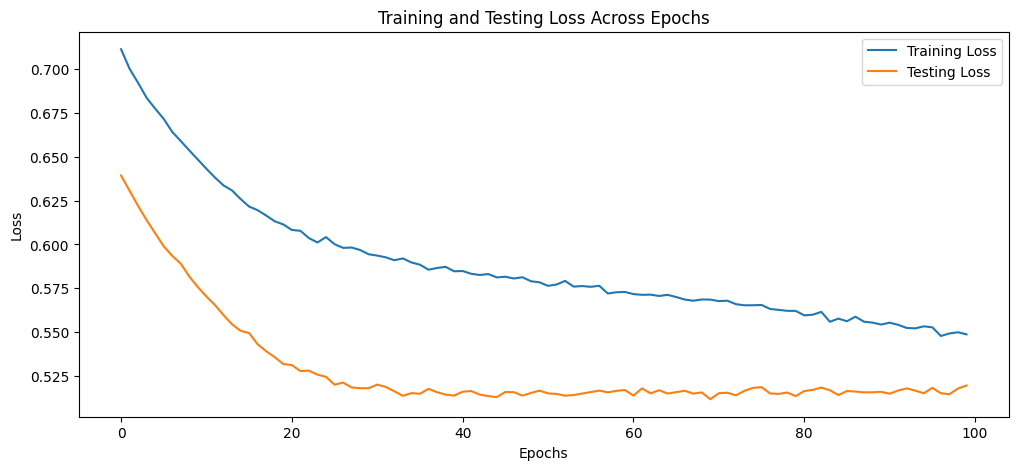

In [ ]:
import matplotlib.pyplot as plt

# Plot training and testing losses across epochs
plt.figure(figsize=(12, 5))
plt.plot(best_model["training_loss"], label="Training Loss")
plt.plot(best_model["testing_loss"], label="Testing Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Testing Loss Across Epochs")
plt.legend()
plt.show()

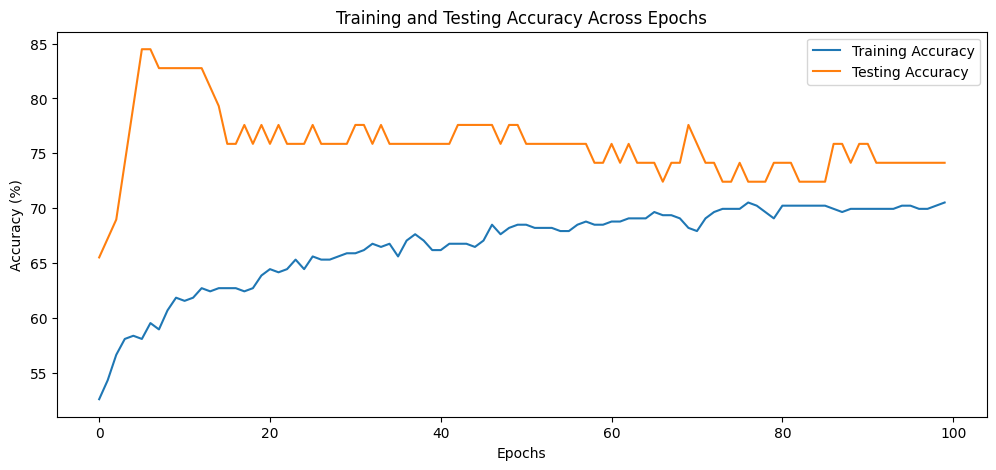

In [ ]:
# Plot training and testing accuracies across epochs
plt.figure(figsize=(12, 5))
plt.plot(best_model["training_accuracy"], label="Training Accuracy")
plt.plot(best_model["testing_accuracy"], label="Testing Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training and Testing Accuracy Across Epochs")
plt.legend()
plt.show()

# Reference

1.   https://medium.com/@shashankshankar10/introduction-to-neural-networks-build-a-single-layer-perceptron-in-pytorch-c22d9b412ccf
2.   https://medium.com/@reddyyashu20/deep-learning-with-pytorch-780be96b2819

